# Deep Learning to Predict Hurricanes

We're going to try and use weather data from the atlantic to predict when storms might occur. To do this we take monthly temperature

In [1]:
import pandas as pd
import os

# load in dataframes containing the datas of the typhoons and hurricanes and the daily temperature records for
# the florida weather stations
daily_temps_df = pd.read_csv("weather_station_temps/all_stations_temp.csv") # dataframe containing daily 
                                                                            # temperatures for weather stations

    
typhoon_df = pd.read_csv("typhoon_data/cleaned_typhoon_data.csv") # dataframe containing dates of hurricanes
                                                                  # and typhoons

typhoon_df.head()

,Unnamed: 0,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,41257,AL042000,UNNAMED,20000808,1200,,TD,28.2,74.2,30,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,41258,AL042000,UNNAMED,20000808,1800,,TD,28.1,75.1,30,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,41259,AL042000,UNNAMED,20000809,0,,TD,28.0,76.0,30,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,41260,AL042000,UNNAMED,20000809,600,,TD,27.9,76.8,30,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,41261,AL042000,UNNAMED,20000809,1200,,TD,27.9,77.4,30,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999



Let's start by trying to plot the position of hurricanes near florida so we know what we're dealing with. We'll do this using basemap, an awesome module for plotting things on 2D maps which will deal with all the cartographic projections. Basemap can be installed at https://www.lfd.uci.edu/~gohlke/pythonlibs/#basemap.

Choose the right version for your python distribution (e.g. I use Python 3.5), put the .whl file in your Python folder (e.g. C:/Python 3.5 for me) and open a command window. Navigate to the python folder and then use **pip install basemap-1.1.0-cp35-cp35m-win_amd64.whl** or whatever the name of the basemap .whl file you downloaded.

If you *really* can't get basemap working, don't worry about it - it's just a nice way to visualize the data. Just skip past this cell and move onto the next one where the machine learning starts.

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


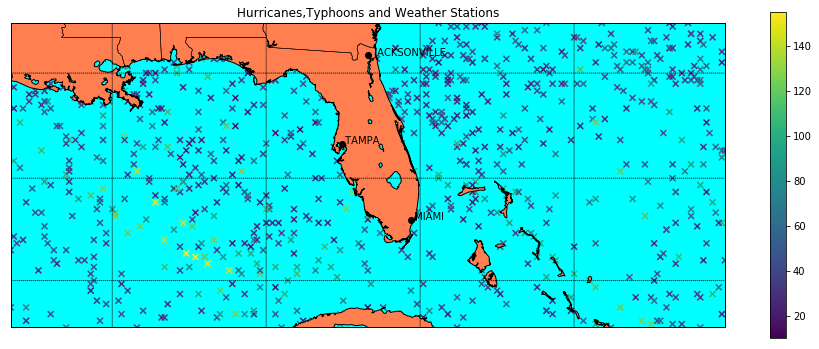

In [2]:
from mpl_toolkits.basemap import Basemap
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.cm import ScalarMappable


plt.figure(figsize=(16,6))
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='merc',llcrnrlat=22.6,urcrnrlat=31.4,\
            llcrnrlon=-93.3,urcrnrlon=-70.1,lat_ts=10,resolution='i')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,3.))
m.drawmeridians(np.arange(-180.,181.,5.))
m.drawmapboundary(fill_color='aqua')
m.drawstates()
#x,y = map(typhoon_df["Longitude"],typhoon_df["Latitude"])p
x,y = m(list(typhoon_df["Longitude"]*-1),list(typhoon_df["Latitude"]))

m.scatter(x,y,c= typhoon_df["Maximum Wind"].values,marker = "x")
plt.colorbar()
weather_station_longitudes,weather_station_latitudes = m([-81.6879,-80.2870,-82.5371], [30.4941,25.7959,27.9835])
weather_station_labels = ["JACKSONVILLE","MIAMI","TAMPA"]
m.plot(weather_station_longitudes,weather_station_latitudes,marker = "o",linestyle=" ",c= "black")
plt.annotate('  JACKSONVILLE', xy=(weather_station_longitudes[0], weather_station_latitudes[0]),\
             xytext=(weather_station_longitudes[0], weather_station_latitudes[0]))
plt.annotate(' TAMPA', xy=(weather_station_longitudes[2], weather_station_latitudes[2]),\
             xytext=(weather_station_longitudes[2], weather_station_latitudes[2]))
plt.annotate(' MIAMI', xy=(weather_station_longitudes[1], weather_station_latitudes[1]),\
             xytext=(weather_station_longitudes[1], weather_station_latitudes[1]))

plt.title("Hurricanes,Typhoons and Weather Stations")
plt.show()

There's quite a lot going on around there! Now we're going to create a dataframe to put our features and labels into which we can use to train our model. For now, we'll use the previous few days of data to make predictions about whether or not a hurricane/typhoon occured on a given day. We will use scikit-learn to split the data into training and test data sets.

In [5]:
import keras
from sklearn.model_selection import train_test_split

labels_and_features_df = pd.read_csv("labels_and_features.csv")
labels_arr = labels_and_features_df["label"]
labels_arr = keras.utils.to_categorical(labels_arr)
features_arr = np.array(labels_and_features_df[labels_and_features_df.columns[1:-1]])

X_train, X_test, y_train, y_test = train_test_split(features_arr, labels_arr, test_size=0.30)

Next we will build our NN Model using Keras. The model consists of an input layer, 2 hiden layers and an output layer. This implementation uses the sigmoid activation unit and the stochastic gradient descent optimizer. The metric used to evaluate the model is accuracy. 

Other activation units unclude 'tanh' and 'relu'. See the Keras documentation for information. 
Other optimizers include 'RMSprop' and 'Adam'. See the Keras documentation for information.

In [7]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=100, activation='sigmoid', input_dim=61))
model.add(Dense(units=100, activation='sigmoid'))
model.add(Dense(units=2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])


In [9]:
history =model.fit(X_train,y_train,epochs = 20,validation_split=0.20)
metric_arr = model.evaluate(X_test,y_test)
print("Loss: " + str(metric_arr[0]), "\nAccuracy: " + str(metric_arr[1]))

Train on 2456 samples, validate on 615 samples
Epoch 1/20
2456/2456 [==============================] - 0s 59us/step - loss: 0.2196 - acc: 0.9414 - val_loss: 0.2606 - val_acc: 0.9268
Epoch 2/20
2456/2456 [==============================] - 0s 44us/step - loss: 0.2196 - acc: 0.9414 - val_loss: 0.2600 - val_acc: 0.9268
Epoch 3/20
2456/2456 [==============================] - 0s 51us/step - loss: 0.2193 - acc: 0.9414 - val_loss: 0.2602 - val_acc: 0.9268
Epoch 4/20
2456/2456 [==============================] - 0s 46us/step - loss: 0.2191 - acc: 0.9414 - val_loss: 0.2603 - val_acc: 0.9268
Epoch 5/20
2456/2456 [==============================] - 0s 44us/step - loss: 0.2189 - acc: 0.9414 - val_loss: 0.2593 - val_acc: 0.9268
Epoch 6/20
2456/2456 [==============================] - 0s 45us/step - loss: 0.2184 - acc: 0.9414 - val_loss: 0.2585 - val_acc: 0.9268
Epoch 7/20
2456/2456 [==============================] - 0s 44us/step - loss: 0.2185 - acc: 0.9414 - val_loss: 0.2580 - val_acc: 0.9268
Epoch 8/

~94% accuracy. This seems pretty good. But lets take a closer look at the outputs

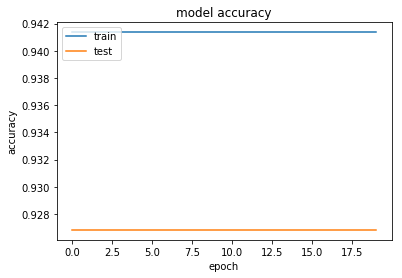

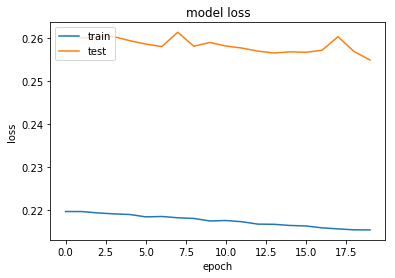

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



Hmm these plots look a bit strange. The model accuracy doesn't change at all during training. Lets look at the confusion matrix. 


Confusion matrix, without normalization
[[1250    0]
 [  67    0]]


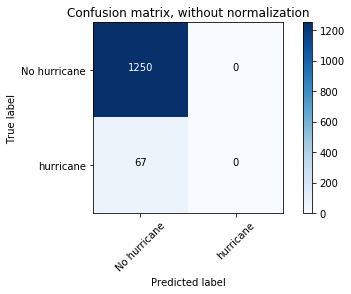

In [11]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
y_prob=model.predict(X_test)
y_pred = y_prob.argmax(axis=-1)
y_test_labels = y_test.argmax(axis=-1)
cnf_matrix=confusion_matrix(y_test_labels, y_pred)
class_names = ['No hurricane','hurricane']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

So it seems we have achieved an accuracy of ~94% by simply assuming there are never any hurricanes. This is casued by the severe imbalance in our dataset. There are ~16 times more hurricane free days then there are days with hurricanes. So this is your goal for the hack night. Find a way to account for the class imbalance and imporve the reliability of the neural network. 

